In [1]:
import optuna
import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import Callback
from torch.utils.data import DataLoader, TensorDataset
import torch

from models.model_v2 import *
from utils.dataset_loader import MaestroV3DataModule

def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
    b1 = trial.suggest_uniform('b1', 0.0, 0.9)
    b2 = trial.suggest_uniform('b2', 0.9, 0.999)
    
    lambda_1 = trial.suggest_float('lambda_1', 0.0, 1.0)
    lambda_2 = trial.suggest_float('lambda_2', 0.0, 1.0)

    latent_dim = trial.suggest_int('latent_dim', 50, 200)
    gen_updates = trial.suggest_int('gen_updates', 1, 5)
    dis_updates = trial.suggest_int('dis_updates', 1, 5)

    mbd_B_dim = trial.suggest_int('mbd_B_dim', 1, 50)
    mbd_C_dim = trial.suggest_int('mbd_C_dim', 1, 50)

    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 72])

    a = trial.suggest_categorical('a', [16, 32, 48, 60, 72, 88, 104, 120, 128])

    apply_mbd = tiral.suggest_categorical("apply_mbd", [True, False])

    # Dataset.
    data_file_path = "data/preprocessed/maestro-v3.0.0/dataset2/1K_dataset.h5"
    dm = MaestroV3DataModule(data_file_path, mode="pair")

    # Initialize model with trial hyperparameters
    model = GAN(latent_dim=latent_dim,
                lr=lr, b1=b1, b2=b2,
                gen_updates=gen_updates,
                dis_updates=dis_updates,
                lambda_1=lambda_1,
                lambda_2=lambda_2,
                mbd_B_dim=mbd_B_dim,
                mbd_C_dim=mbd_C_dim,
                batch_size=batch_size,
                apply_mbd=apply_mbd,
                a=a
    )

    # Logger and callbacks
    checkpoint_callback = ModelCheckpoint(monitor='g_loss', mode='min', save_top_k=1)

    # Trainer
    trainer = Trainer(
        callbacks=[checkpoint_callback],
        max_epochs=10,
        accelerator="auto",
    )

    # Train
    trainer.fit(model, dm)

    # Retrieve best metric
    return checkpoint_callback.best_model_score.item()

/usr/lib/python3.13/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.1 is exactly one major version older than the runtime version 6.31.1 at api.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Best trial:')
trial = study.best_trial
print(f'  Value: {trial.value}')
print('  Params:')
for key, val in trial.params.items():
    print(f'    {key}: {val}')

[I 2025-07-16 18:31:09,103] A new study created in memory with name: no-name-fd0f810f-670d-494c-b755-4d4b799c3007
/tmp/ipykernel_49849/33919853.py:16: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-2)
/tmp/ipykernel_49849/33919853.py:17: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  b1 = trial.suggest_uniform('b1', 0.0, 0.9)
/tmp/ipykernel_49849/33919853.py:18: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  b2 = trial.suggest_uniform('b2', 0.9, 0.999)
GPU available: True (cuda), used: True
TPU available: 

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.66it/s, v_num=387, d_loss=0.329, g_loss=6.500]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.62it/s, v_num=387, d_loss=0.329, g_loss=6.500]


[I 2025-07-16 18:31:22,855] Trial 0 finished with value: 0.47491776943206787 and parameters: {'lr': 0.0023662908281038065, 'b1': 0.08735207572803007, 'b2': 0.9316129622495016, 'lambda_1': 0.9644689668391763, 'lambda_2': 0.23088889505353316, 'latent_dim': 170, 'gen_updates': 4, 'dis_updates': 3, 'mbd_B_dim': 19, 'mbd_C_dim': 23, 'batch_size': 16, 'a': 128}. Best is trial 0 with value: 0.47491776943206787.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 580 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
826 K     Trainable params
0         Non-trainable params
826 K     Total params
3.307     Total estimated model params size (MB)
56        Modules in train mode
0   

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.57it/s, v_num=388, d_loss=1.370, g_loss=0.798]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 37.53it/s, v_num=388, d_loss=1.370, g_loss=0.798]


[I 2025-07-16 18:31:36,191] Trial 1 finished with value: 0.7876414656639099 and parameters: {'lr': 2.4691276907329113e-05, 'b1': 0.6800699787926855, 'b2': 0.9761063041993174, 'lambda_1': 0.754477347072067, 'lambda_2': 0.6419059928263968, 'latent_dim': 112, 'gen_updates': 4, 'dis_updates': 3, 'mbd_B_dim': 5, 'mbd_C_dim': 29, 'batch_size': 64, 'a': 60}. Best is trial 0 with value: 0.47491776943206787.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 680 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
926 K     Trainable params
0         Non-trainable params
926 K     Total params
3.708     Total estimated model params size (MB)
56        Modules in train mode
0        

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.59it/s, v_num=389, d_loss=0.438, g_loss=9.630]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 34.57it/s, v_num=389, d_loss=0.438, g_loss=9.630]


[I 2025-07-16 18:31:50,637] Trial 2 finished with value: 0.06876721978187561 and parameters: {'lr': 0.0051570139729141306, 'b1': 0.48580737687313796, 'b2': 0.9288852734922046, 'lambda_1': 0.9387471013164725, 'lambda_2': 0.6244018738194345, 'latent_dim': 66, 'gen_updates': 4, 'dis_updates': 4, 'mbd_B_dim': 8, 'mbd_C_dim': 34, 'batch_size': 32, 'a': 128}. Best is trial 2 with value: 0.06876721978187561.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 616 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
863 K     Trainable params
0         Non-trainable params
863 K     Total params
3.453     Total estimated model params size (MB)
56        Modules in train mode
0      

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.47it/s, v_num=390, d_loss=0.327, g_loss=8.020]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 43.43it/s, v_num=390, d_loss=0.327, g_loss=8.020]


[I 2025-07-16 18:32:02,186] Trial 3 finished with value: 0.7850778102874756 and parameters: {'lr': 0.003939395316269488, 'b1': 0.145896344224725, 'b2': 0.9505255135434147, 'lambda_1': 0.09299650864002029, 'lambda_2': 0.9472325108948141, 'latent_dim': 191, 'gen_updates': 2, 'dis_updates': 4, 'mbd_B_dim': 50, 'mbd_C_dim': 44, 'batch_size': 16, 'a': 32}. Best is trial 2 with value: 0.06876721978187561.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 607 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
854 K     Trainable params
0         Non-trainable params
854 K     Total params
3.417     Total estimated model params size (MB)
56        Modules in train mode
0        

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.62it/s, v_num=391, d_loss=0.337, g_loss=6.390]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 32.60it/s, v_num=391, d_loss=0.337, g_loss=6.390]


[I 2025-07-16 18:32:17,850] Trial 4 finished with value: 0.9095302820205688 and parameters: {'lr': 0.0007688585381950213, 'b1': 0.48437825465340595, 'b2': 0.9410062089378837, 'lambda_1': 0.9860972302042496, 'lambda_2': 0.5956049863949521, 'latent_dim': 52, 'gen_updates': 4, 'dis_updates': 5, 'mbd_B_dim': 36, 'mbd_C_dim': 43, 'batch_size': 72, 'a': 104}. Best is trial 2 with value: 0.06876721978187561.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 648 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
895 K     Trainable params
0         Non-trainable params
895 K     Total params
3.581     Total estimated model params size (MB)
56        Modules in train mode
0      

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.12it/s, v_num=392, d_loss=0.505, g_loss=5.280]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 36.10it/s, v_num=392, d_loss=0.505, g_loss=5.280]


[I 2025-07-16 18:32:32,059] Trial 5 finished with value: 0.04525423422455788 and parameters: {'lr': 0.007042999705570105, 'b1': 0.0806640259552736, 'b2': 0.914177508686712, 'lambda_1': 0.14540658723349498, 'lambda_2': 0.9393229432661905, 'latent_dim': 92, 'gen_updates': 3, 'dis_updates': 5, 'mbd_B_dim': 37, 'mbd_C_dim': 47, 'batch_size': 16, 'a': 104}. Best is trial 5 with value: 0.04525423422455788.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 595 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
841 K     Trainable params
0         Non-trainable params
841 K     Total params
3.367     Total estimated model params size (MB)
56        Modules in train mode
0       

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.76it/s, v_num=393, d_loss=0.888, g_loss=1.600]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 63.68it/s, v_num=393, d_loss=0.888, g_loss=1.600]


[I 2025-07-16 18:32:40,155] Trial 6 finished with value: 0.7957150340080261 and parameters: {'lr': 0.00018382839244020455, 'b1': 0.3258841529041485, 'b2': 0.9705711925273952, 'lambda_1': 0.633194192651097, 'lambda_2': 0.1910710572944071, 'latent_dim': 170, 'gen_updates': 2, 'dis_updates': 1, 'mbd_B_dim': 11, 'mbd_C_dim': 2, 'batch_size': 72, 'a': 32}. Best is trial 5 with value: 0.04525423422455788.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 581 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
827 K     Trainable params
0         Non-trainable params
827 K     Total params
3.312     Total estimated model params size (MB)
56        Modules in train mode
0        

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.10it/s, v_num=394, d_loss=0.754, g_loss=2.160]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 47.05it/s, v_num=394, d_loss=0.754, g_loss=2.160]


[I 2025-07-16 18:32:50,610] Trial 7 finished with value: 0.7062475085258484 and parameters: {'lr': 0.006324564617526195, 'b1': 0.5798319518504667, 'b2': 0.9728600943506099, 'lambda_1': 0.9522362645484128, 'lambda_2': 0.37362462257990636, 'latent_dim': 113, 'gen_updates': 3, 'dis_updates': 2, 'mbd_B_dim': 27, 'mbd_C_dim': 11, 'batch_size': 64, 'a': 60}. Best is trial 5 with value: 0.04525423422455788.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 798 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
1.0 M     Trainable params
0         Non-trainable params
1.0 M     Total params
4.179     Total estimated model params size (MB)
56        Modules in train mode
0       

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.34it/s, v_num=395, d_loss=0.474, g_loss=5.640]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 39.30it/s, v_num=395, d_loss=0.474, g_loss=5.640]


[I 2025-07-16 18:33:03,397] Trial 8 finished with value: 0.7898179888725281 and parameters: {'lr': 0.0001298354826909082, 'b1': 0.3918481412504847, 'b2': 0.9440018840801424, 'lambda_1': 0.05907699174072045, 'lambda_2': 0.08401366394533372, 'latent_dim': 181, 'gen_updates': 2, 'dis_updates': 5, 'mbd_B_dim': 14, 'mbd_C_dim': 6, 'batch_size': 16, 'a': 128}. Best is trial 5 with value: 0.04525423422455788.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | Mode 
--------------------------------------------------------
0 | generator     | Generator     | 678 K  | train
1 | discriminator | Discriminator | 246 K  | train
--------------------------------------------------------
925 K     Trainable params
0         Non-trainable params
925 K     Total params
3.701     Total estimated model params size (MB)
56        Modules in train mode
0     

Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.03it/s, v_num=396, d_loss=0.624, g_loss=2.210]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:01<00:00, 45.00it/s, v_num=396, d_loss=0.624, g_loss=2.210]


[I 2025-07-16 18:33:14,523] Trial 9 finished with value: 0.8853256702423096 and parameters: {'lr': 0.0007901667914934578, 'b1': 0.3662225272799975, 'b2': 0.939110551227065, 'lambda_1': 0.2262663477622755, 'lambda_2': 0.9957520731321639, 'latent_dim': 84, 'gen_updates': 3, 'dis_updates': 2, 'mbd_B_dim': 25, 'mbd_C_dim': 26, 'batch_size': 32, 'a': 120}. Best is trial 5 with value: 0.04525423422455788.


Best trial:
  Value: 0.04525423422455788
  Params:
    lr: 0.007042999705570105
    b1: 0.0806640259552736
    b2: 0.914177508686712
    lambda_1: 0.14540658723349498
    lambda_2: 0.9393229432661905
    latent_dim: 92
    gen_updates: 3
    dis_updates: 5
    mbd_B_dim: 37
    mbd_C_dim: 47
    batch_size: 16
    a: 104


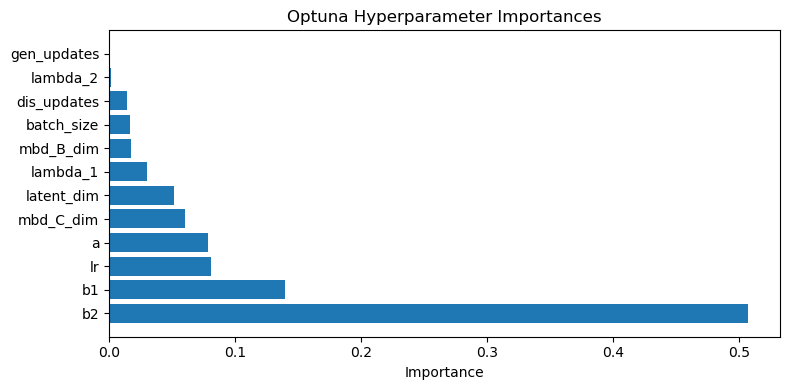

In [3]:
# If you prefer a quick matplotlib bar chart instead of Plotly:
from optuna.importance import get_param_importances
import matplotlib.pyplot as plt

imp = get_param_importances(study)
names = list(imp.keys())
scores = list(imp.values())

plt.figure(figsize=(8,4))
plt.barh(names, scores)
plt.xlabel("Importance")
plt.title("Optuna Hyperparameter Importances")
plt.tight_layout()
plt.show()